# Injection Test
- In this script, we test szifi by injecting 300 point sources into a map then attempting to recover them.

In [208]:
## Imports
%pylab inline
import szifi
import healpy as hp

## Directories
output_dir = '/mnt/home/ophilcox/szifi_hotspot/outputs_injected/'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Load szifi

In [68]:
### DEFAULT PARAMETERS
params_szifi = szifi.params_szifi_default
params_data = szifi.params_data_default
params_model = szifi.params_model_default

# Data paths
params_szifi['path'] = '/mnt/home/ophilcox/szifi_hotspot/' # main code
params_data["field_ids"] = []
params_data['data_set'] = 'Planck_pr4_compsep' # specifies szifi settings for the beam (experiment dependent)

# Load cosmology parameters
import camb
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.32, ombh2=0.022383, omch2=0.12011,tau=0.0543,mnu=0.06,omk=0,standard_neutrino_neff=True)
back = camb.get_background(pars)
eta_rec = back.tau_maxvis # comoving horizon at last-scattering
eta_0 = back.tau0 # comoving horizon today
chi_rec = eta_0-eta_rec # distance to comoving horizon

# Define range of template parameters
theta_500 = np.geomspace(0.5,15.,15) # theta500 (only used for tSZ)
all_eta_star = np.geomspace(10,1000,10) # eta_* in Mpc

# Define collapsed 1D grids of eta_* and eta_HS
eta_stars = []
eta_hss = []
for i in range(len(all_eta_star)):
    # Ensure that the hotspot is at the right distance
    chi_HSs = np.linspace(max(chi_rec-all_eta_star[i],0),min(chi_rec+all_eta_star[i],eta_0),12)[1:-1]
    eta_HSs = eta_0-chi_HSs
    for j in range(len(eta_HSs)):
        eta_stars.append(all_eta_star[i])
        eta_hss.append(eta_HSs[j])
eta_stars = np.asarray(eta_stars)
eta_hss = np.asarray(eta_hss)

# Load into szifi parameters
params_szifi['theta_500_vec_arcmin'] = theta_500
params_szifi['eta_star_vec'] = eta_stars
params_szifi['eta_hs_vec'] = eta_hss

# Some other options
params_szifi['iterative'] = False
params_szifi['lrange'] = [30,3000]

# Other parameters
params_szifi['inpaint'] = True
params_szifi['deproject_cib'] = None
params_szifi['estimate_spec'] = 'estimate'
params_szifi['save_coupling_matrix'] = True

# SNR threshold to consider a preliminary "detection"
params_szifi['q_th'] = 4.0
params_szifi['q_th_noise'] = 4.0
params_szifi['freqs'] = []

data = szifi.input_data(params_szifi=params_szifi,params_data=params_data)

## Create Injection Map
Below, we create a full-sky HEALPix map containing 300 fake hotspots with the true profiles.

In [153]:
# eta_* values
all_eta_star = np.geomspace(10,1000,10)

# Simulation ID
sim_no = 0

First, we'll create a catalog of randomly distributed hotspot positions and sizes, with at least 3 degree separation.

In [168]:
## Define positions (without selection)
n_cluster = 300
nside = 4096

# Define seed
np.random.seed(n_cluster*42+int(1e5)*sim_no+int(1e6))

# Draw random positions on the sky
lon,lat = hp.pix2ang(nside, np.random.randint(0,hp.nside2npix(nside),n_cluster+100), lonlat=True)
print("Started with %d objects"%len(lon))

# Delete closely separated objects
bad_i = []
for i in range(len(lon)-1):
    if np.min(hp.rotator.angdist([lon[i],lat[i]],[lon[i+1:],lat[i+1:]]))<3.*60*np.pi/180./60.: 
        bad_i.append(i)

print("Deleting %d too-close objects"%len(bad_i))
lon,lat = np.delete(lon,bad_i), np.delete(lat, bad_i)

# Create final catalog
lon,lat = lon[:n_cluster], lat[:n_cluster]
assert len(lon)==n_cluster

# Define eta-star values
rand_ind = np.random.choice(np.arange(n_cluster), replace=False, size=n_cluster)
rand_ind = np.random.choice(np.arange(n_cluster), replace=False, size=n_cluster) # this line is duplicated just so I get the same seed I used before
eta_ind = np.repeat(np.arange(len(all_eta_star)),n_cluster/len(all_eta_star))[rand_ind]
eta_stars = all_eta_star[eta_ind]

Started with 400 objects
Deleting 86 too-close objects


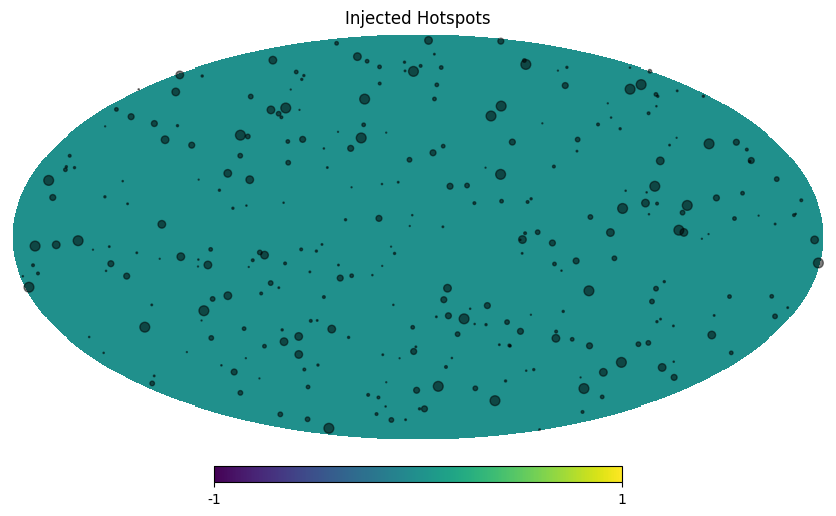

In [169]:
np.savez('injection300_v3_sim%d.npz'%sim_no, lon=lon, lat=lat, eta_stars=eta_stars)

hp.mollview(np.zeros(hp.nside2npix(nside)),title='Injected Hotspots')
hp.projscatter(lon,lat,lonlat=True,s=eta_stars/20,c='k',alpha=0.5)

Next, we will build each hotspot profile, truncating appropriately.

In [170]:
xymap = np.meshgrid(np.arange(-data.nx/2,data.nx/2)*data.dx,np.arange(-data.nx/2,data.nx/2)*data.dx)
dismap = np.sqrt(xymap[0]**2+xymap[1]**2)
inds = np.argsort(dismap.ravel())[::-1]   
from scipy.interpolate import interp1d
    
tem_interps = []
max_dis = []
for i in range(len(all_eta_star)):
    print("Building profile %d of %d"%(i+1,len(all_eta_star)))
    this_eta_star = all_eta_star[i]
    this_eta_hs = eta_rec

    # Define the profile and load into szifi
    png_model = szifi.model.png({'eta_star':this_eta_star,'eta_hs':this_eta_hs},kmin=1e-6,kmax=1,lmax=3500,reduce_k=20,type="soubhik")
    data = szifi.input_data(params_szifi=params_szifi,params_data=params_data)

    # Create the beam-convolved hotspot profile
    t_tem = png_model.get_t_map_convolved(data.pix,data.data['experiment'], theta_misc=[0.-data.dx/2,0-data.dx/2],beam='real', get_nc=False,sed=None)
    rel_t = np.abs(t_tem[:,:,0]/np.max(np.abs(t_tem[:,:,0]))).ravel()
    # Truncate the profile when the size is < 0.1% of the total size (or use a weaker criterion if the profile is too big)
    thresh = 1e-3
    while True:
        try:
            dis_max = dismap.ravel()[inds][np.where(np.diff(rel_t[inds]<thresh))[0][0]]
            break
        except IndexError:
            thresh *= 1.1
    
    tem_interps.append(interp1d(dismap[dismap<dis_max],np.asarray([t_tem[:,:,j][dismap<dis_max] for j in range(1)]), fill_value=0, bounds_error=False))
    max_dis.append(dis_max)
    print("0.1%% scale: %.3f radians"%dis_max)

Building profile 1 of 10
Maximum scale: 0.100 radians
0.1% scale: 0.024 radians
Building profile 2 of 10
Maximum scale: 0.100 radians
0.1% scale: 0.023 radians
Building profile 3 of 10
Maximum scale: 0.100 radians
0.1% scale: 0.024 radians
Building profile 4 of 10
Maximum scale: 0.100 radians
0.1% scale: 0.027 radians
Building profile 5 of 10
Maximum scale: 0.100 radians
0.1% scale: 0.035 radians
Building profile 6 of 10
Maximum scale: 0.100 radians
0.1% scale: 0.011 radians
Building profile 7 of 10
Maximum scale: 0.100 radians
0.1% scale: 0.051 radians
Building profile 8 of 10
Maximum scale: 0.100 radians
0.1% scale: 0.047 radians
Building profile 9 of 10
Maximum scale: 0.150 radians
0.1% scale: 0.057 radians
Building profile 10 of 10
Maximum scale: 0.250 radians
0.1% scale: 0.080 radians


Finally, we'll paint the profile to the map, assuming g=1. (We can scale by g later).

In [171]:
nside = 2048
template_map = np.zeros((hp.nside2npix(nside), 1))

for profile_id in range(len(lon)):
    if profile_id%10==0: print("Adding profile %d"%profile_id)
    n_close = 0
    # Compute all close pixels
    close_pix = hp.ang2pix(nside, lon[profile_id], lat[profile_id], lonlat=True)
    for i in range(500):
        close_pix = np.unique(np.concatenate([np.asarray(close_pix).ravel(),
                                              hp.get_all_neighbours(nside, close_pix).ravel()]))
        # Check distances
        dis = hp.rotator.angdist(hp.pix2ang(nside, close_pix, lonlat=True), (lon[profile_id], lat[profile_id]), lonlat=True)
        eta_ind = np.where(eta_stars[profile_id]==all_eta_star)[0][0]
        if n_close==np.sum(dis<max_dis[eta_ind]): break
        n_close = np.sum(dis<max_dis[eta_ind])
        if i==499: print("Not all neighbors found!")

    # Apply template (using the relevant interpolator)
    template_map[close_pix,:] += tem_interps[eta_ind](dis).T

# Remove empty pixels
template_map[-1,0] = 0
# Save output
hp.write_map('/mnt/home/ophilcox/ceph/szifi_cutouts_new/cutout300_v3_sim%d_sep.fits'%sim_no, template_map.T, overwrite=True)

Adding profile 0
Adding profile 10
Adding profile 20
Adding profile 30
Adding profile 40
Adding profile 50
Adding profile 60
Adding profile 70
Adding profile 80
Adding profile 90
Adding profile 100
Adding profile 110
Adding profile 120
Adding profile 130
Adding profile 140
Adding profile 150
Adding profile 160
Adding profile 170
Adding profile 180
Adding profile 190
Adding profile 200
Adding profile 210
Adding profile 220
Adding profile 230
Adding profile 240
Adding profile 250
Adding profile 260
Adding profile 270
Adding profile 280
Adding profile 290


setting the output map dtype to [dtype('float64')]


Let's plot the map.

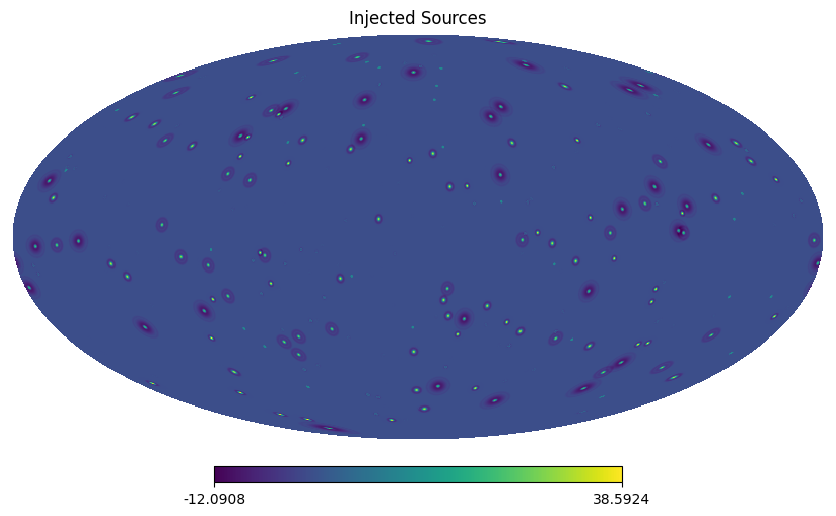

In [172]:
hp.mollview(template_map[:,0],title='Injected Sources');

## Hotspot Analysis

### Plot the simulation and the mask

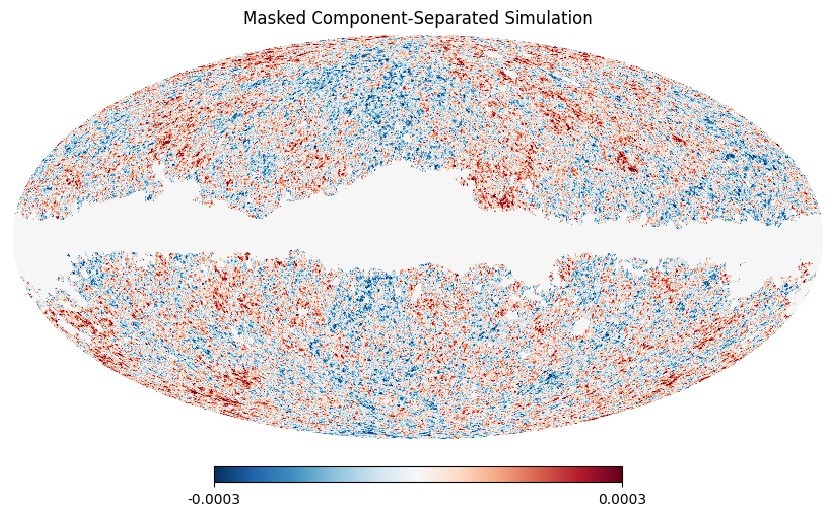

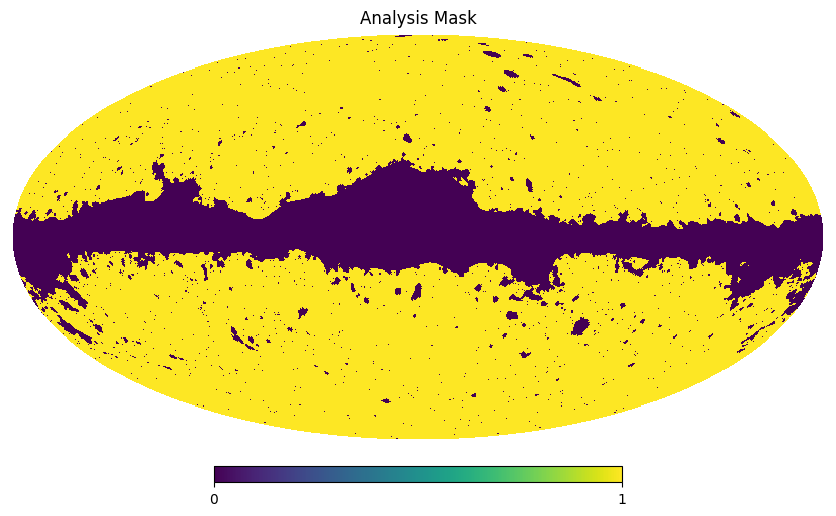

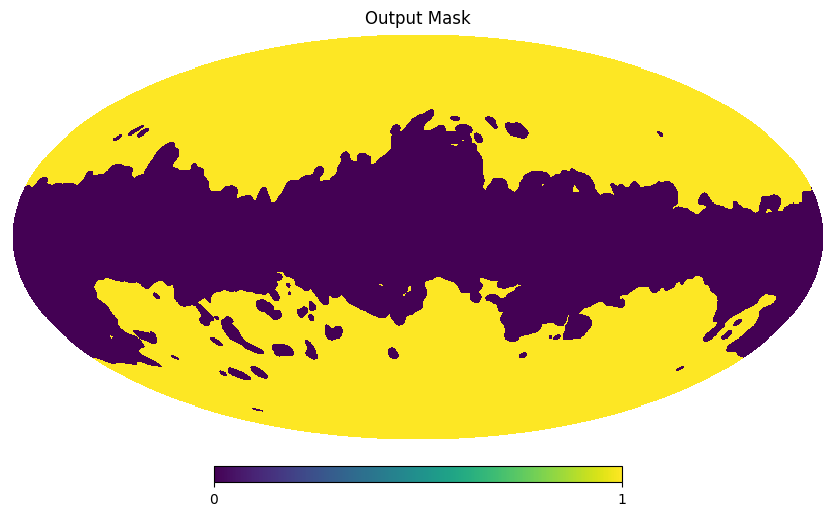

In [56]:
### Raw temperature data
obs = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/sevem/SEVEM_NPIPE_sims/SEVEM_NPIPE_cmb_sim%s.fits'%(str(sim_no+200).zfill(4)))+hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/sevem/SEVEM_NPIPE_sims/SEVEM_NPIPE_noise_sim%s.fits'%(str(sim_no+200).zfill(4))) 
### Analysis masks (temperature)
# Standard mask
mask = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')
# Extra inpainting mask (not used for point detection)
inp_mask = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_CMB-Inpainting-Mask-Int_2048_R3.00.fits')
### Output mask 
# We use a more conservative mask to evaluate detections
# This is the same masked used in tSZ cluster searches
sz_mask = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_Compton-SZMap_2048_R2.00.fits')

hp.mollview(mask*obs, max=0.0003, min=-0.0003, cmap=cm.RdBu_r, title='Masked Component-Separated Simulation')
hp.mollview(mask,title='Analysis Mask')
hp.mollview(sz_mask, title='Output Mask')

### Load Hotspots

In [72]:
def load_png_catalog(g):
    """Load a hotspot catalog from file, combining all tiles present."""
    i = 0
    for batch in range(768):
        if g==0:
            name = output_dir+'ffp10_sep_%d_batch%d_soubhik.npy'%(sim_no,batch)
        else:
            name = output_dir+'ffp10_sep_%d_batch%d_soubhik_inj-g%.2f.npy'%(sim_no,batch,g)
        try:
            if i==0:
                if 'eta_star' in np.load(name,allow_pickle=True).item().catalogue.keys():
                    tot_cat = np.load(name,allow_pickle=True).item()
                    i += 1
                else:
                    continue
            else:
                try:
                    tot_cat.append(np.load(name,allow_pickle=True).item())
                except KeyError:
                    pass;
                i += 1
        except IOError:
            continue
    if i!=0:
        print("Found %d PNG hotspots (SNR>4) from %d catalogues"%(len(tot_cat.catalogue['q_opt']),i))
    else:
        raise Exception("No g=%s catalogs found"%g)
    return tot_cat

# Cut to SNR of 4
snr_min = 5
sim_no = 0
gs = [0,10,20,30,50]
png_gs = []
for g in gs:
    png_gs.append(szifi.get_catalogue_q_th(load_png_catalog(g), snr_min))

Found 1861 PNG hotspots (SNR>4) from 78 catalogues
Found 2344 PNG hotspots (SNR>4) from 78 catalogues
Found 2922 PNG hotspots (SNR>4) from 78 catalogues
Found 3134 PNG hotspots (SNR>4) from 78 catalogues
Found 4169 PNG hotspots (SNR>4) from 78 catalogues


### Useful Functions

In [73]:
def remove_point_sources(input_cat, exclusion_factor=5):
    """Given a 6-frequency point-source catalog (point_cat), remove any hotspot candidates within 5*FWHM of the point-sources.""" 
    good_inds = []
    for c in range(len(input_cat.catalogue['q_opt'])):
        clon = input_cat.catalogue['lon'][c]
        clat = input_cat.catalogue['lat'][c]

        bad = False
        for f in range(6):
            theta_beam = data.data['experiment'].FWHM[f]/(2.*np.sqrt(2.*np.log(2)))*np.pi/180./60. # beam width in radians

            cdis = hp.rotator.angdist((clon,clat),(point_cat[f].catalogue['lon'],point_cat[f].catalogue['lat']),lonlat=True)
            if np.min(cdis)<exclusion_factor*theta_beam: bad=True

        if not bad:
            good_inds.append(c)

    return szifi.cat.get_catalogue_indices(input_cat, good_inds)

def remove_cat(input_cat, removal_cat, dis_arcmin=10):
    """"Remove any hotspot candidates within 10' of sources in another catalog."""
    good_inds = []
    for c in range(len(input_cat.catalogue['q_opt'])):
        clon = input_cat.catalogue['lon'][c]
        clat = input_cat.catalogue['lat'][c]

        cdis = hp.rotator.angdist((clon,clat),(removal_cat.catalogue['lon'],removal_cat.catalogue['lat']),lonlat=True)
        if not np.min(cdis)<dis_arcmin*np.pi/180./60.:
            good_inds.append(c)

    return szifi.cat.get_catalogue_indices(input_cat, good_inds)

def cut_on_map(input_cat, mask_map):
    """Remove any hotspot candidates that are outside the mask of interest"""
    return szifi.cat.get_catalogue_indices(input_cat, np.where(mask_map[hp.ang2pix(2048,input_cat.catalogue['lon'],input_cat.catalogue['lat'],lonlat=True)]))

def merge_cat(catalogue, size_factor=0.2,verb=True):
    """Merge catalogs together combining overlapping sources."""
    len_pre = np.inf
    len_post = -1
    it = 0
    while len_pre!=len_post: 
        len_pre = len(catalogue.catalogue['q_opt'])
        catalogue = _merge_cat(catalogue, size_factor=size_factor, verb=verb)
        len_post = len(catalogue.catalogue['q_opt'])
        it +=1
    print('Finished in %d iterations'%it)
    return catalogue

def _merge_cat(catalogue,size_factor=0.2,verb=True):
    catalogue = szifi.cat.get_catalogue_indices(catalogue,np.where(catalogue.catalogue["q_opt"] != -1.)[0])
    n_clusters = len(catalogue.catalogue["q_opt"])
    catalogue_merged = szifi.cat.cluster_catalogue()
    catalogue_compare = catalogue

    i = 0

    indices_subtract = np.arange(len(catalogue_compare.catalogue["q_opt"]))
    merge_flags = np.zeros(0)

    while len(indices_subtract) > 0:
        catalogue_compare_new = szifi.cat.cluster_catalogue()

        for key in catalogue_compare.catalogue.keys():
            if len(catalogue_compare.catalogue[key]) > 0.:
                catalogue_compare_new.catalogue[key] = catalogue_compare.catalogue[key][indices_subtract]

        catalogue_compare = catalogue_compare_new

        n_clusters = len(catalogue_compare.catalogue["q_opt"])
        dist = szifi.sphere.get_angdist(catalogue_compare.catalogue["lon"][0]*np.ones(n_clusters),catalogue_compare.catalogue["lon"],
        catalogue_compare.catalogue["lat"][0]*np.ones(n_clusters),catalogue_compare.catalogue["lat"])
        
        dist_thresh = np.sqrt(4.*np.pi)*size_factor*(catalogue_compare.catalogue['eta_star'][0]+catalogue_compare.catalogue['eta_star'])/eta_0
        indices = np.where(dist <= dist_thresh)[0]
        merge_flags = np.append(merge_flags,len(indices))
        
        index_max = indices[np.argmax(catalogue_compare.catalogue["q_opt"][indices])]
        catalogue_new = szifi.cat.cluster_catalogue()

        for key in catalogue_compare.catalogue.keys():
            if len(catalogue_compare.catalogue[key]) > 0.:
                catalogue_new.catalogue[key] = np.array([catalogue_compare.catalogue[key][index_max]])

        catalogue_merged.append(catalogue_new,append_keys="new")
        indices_subtract = np.setdiff1d(np.arange(len(catalogue_compare.catalogue["q_opt"])),indices)
        
        i += 1

    if verb: print("Start size: %d, end size: %d"%(len(catalogue.catalogue['q_opt']),len(catalogue_merged.catalogue['q_opt'])))
    return catalogue_merged

### Process the hotspot catalog
Here we'll combine together the overlapping candidates and make various cuts based on the mask. We can optionally remove sources too close to known point-sources or tSZ clusters. For this, we can run a full frequency search for point-sources and/or tSZ clusters (using a modified version of the injected_analysis script). 

In [184]:
def process_png(_png_cat, merge_radius=10, point_exclusion_factor=5, sz_radius=10):
    """Process a PNG catalogue, applying various cuts"""
    
    print("\nStarted with %d PNG hotspots"%len(_png_cat.catalogue['q_opt']))
    
    # Apply the output mask
    png_cat = cut_on_map(_png_cat, sz_mask)
    print("Found %d PNG hotspots after SZ mask cut"%len(png_cat.catalogue['q_opt']))
    
    # Remove galactic plane
    #png_cat = cut_on_map(png_cat, gal70)
    #print("Found %d PNG hotspots after 70%% galactic plane cut"%len(png_cat.catalogue['q_opt']))
    
    # Remove nearby point-sources
    try:
        png_cat = remove_point_sources(png_cat, exclusion_factor=point_exclusion_factor)
        print("Found %d PNG hotspots after point-source cut"%len(png_cat.catalogue['q_opt']))
    except NameError:
        print("No point-source cut!")
        pass
    
    # Remove SZ sources
    try:    
        png_cat = remove_cat(png_cat, sz_cat_nopoint.catalogue, dis_arcmin=sz_radius)
        print("Found %d PNG hotspots after SZ-source cut"%len(png_cat.catalogue['q_opt']))
    except NameError:
        print("No SZ-source cut!")
        pass
    
    # Merge sources
    png_cat = szifi.merge_detections(png_cat,radius_arcmin=merge_radius,return_merge_flag=False,mode="closest")
    print("Found %d merged PNG hotspots"%len(png_cat.catalogue['q_opt']))
    
    # Return
    return png_cat

png_g_procs = [process_png(png_g, merge_radius=10, point_exclusion_factor=5, sz_radius=10) for png_g in png_gs]


Started with 51 PNG hotspots
Found 24 PNG hotspots after SZ mask cut
No point-source cut!
No SZ-source cut!
Found 22 merged PNG hotspots

Started with 206 PNG hotspots
Found 153 PNG hotspots after SZ mask cut
No point-source cut!
No SZ-source cut!
Found 87 merged PNG hotspots

Started with 712 PNG hotspots
Found 557 PNG hotspots after SZ mask cut
No point-source cut!
No SZ-source cut!
Found 267 merged PNG hotspots

Started with 902 PNG hotspots
Found 698 PNG hotspots after SZ mask cut
No point-source cut!
No SZ-source cut!
Found 318 merged PNG hotspots

Started with 1891 PNG hotspots
Found 953 PNG hotspots after SZ mask cut
No point-source cut!
No SZ-source cut!
Found 381 merged PNG hotspots


### Plot the Hotspot Candidates

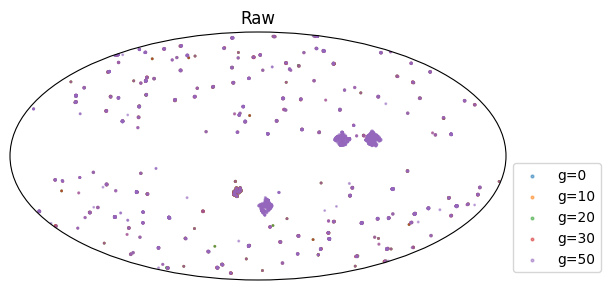

In [185]:
def plot_cat(cat, ssig,label,size=1, alpha=1):
    lat = cat.catalogue['lat'][cat.catalogue['q_opt']>ssig]
    lon = cat.catalogue['lon'][cat.catalogue['q_opt']>ssig]
    snr = cat.catalogue['q_opt'][cat.catalogue['q_opt']>ssig]
    ax.scatter(np.radians(lon-180),np.radians(lat),s=5*size*(snr/ssig)**1,alpha=alpha,label=label)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
ax.set_title('Raw')

# Plot all SNR > 5 candidates
snr_min = 5
for gi,g in enumerate(gs):
    plot_cat(png_gs[gi], snr_min, 'g=%d'%g, alpha=0.5,size=0.2)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([]);
ax.legend(bbox_to_anchor=(1.,0.5),ncol=1);

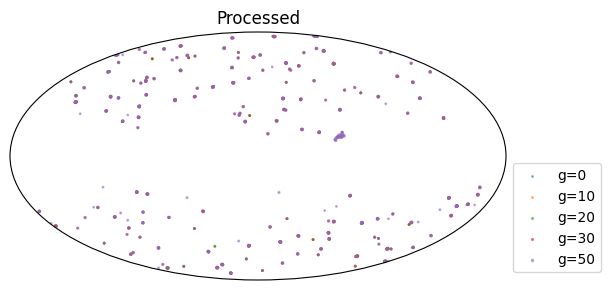

In [186]:
def plot_cat(cat, ssig,label,size=1, alpha=1):
    lat = cat.catalogue['lat'][cat.catalogue['q_opt']>ssig]
    lon = cat.catalogue['lon'][cat.catalogue['q_opt']>ssig]
    snr = cat.catalogue['q_opt'][cat.catalogue['q_opt']>ssig]
    ax.scatter(np.radians(lon-180),np.radians(lat),s=5*size*(snr/ssig)**1,alpha=alpha,label=label)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
ax.set_title('Processed')

# Plot processed SNR > 5 candidates
snr_min = 5
for gi,g in enumerate(gs):
    plot_cat(png_g_procs[gi], snr_min, 'g=%d'%g, alpha=0.5,size=0.2)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([]);
ax.legend(bbox_to_anchor=(1.,0.5),ncol=1);

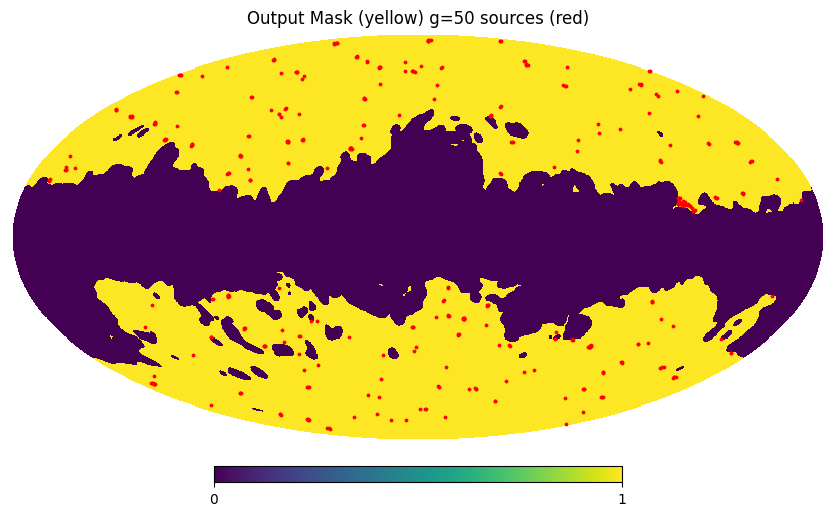

In [187]:
ss = 5
gi = -1
hp.mollview(sz_mask,title='Output Mask (yellow) g=%d sources (red)'%(gs[gi]))
hp.projscatter(png_g_procs[gi].catalogue['lon'][png_g_procs[gi].catalogue['q_opt']>ss],png_g_procs[gi].catalogue['lat'][png_g_procs[gi].catalogue['q_opt']>ss],
               s=3,lonlat=True,c='r')

### Match against true catalog

In [188]:
true_cat2 = np.load('../szifi/injection300_v2_sim%d.npz'%sim_no)
true_cat3 = np.load('injection300_v3_sim%d.npz'%sim_no)

In [189]:
true_cat = np.load('../szifi/injection300_v2_sim%d.npz'%sim_no)
all_eta_star = np.geomspace(10,1000,10)

def identify_true_sources(input_cat, dis_arcmin=10):
    """Check which sources appear in the true catalog. We declare a match if the distance is < 10 arcmin"""
    
    lon = input_cat.catalogue['lon']
    lat = input_cat.catalogue['lat']

    match_sources = []
    all_close = []
    for t in range(len(true_cat['lon'])):
        
        tdis = hp.rotator.angdist((true_cat['lon'][t],true_cat['lat'][t]),(lon,lat),lonlat=True)
        
        dist_thresh = dis_arcmin*np.pi/180./60.
        close_ids = np.where(tdis<dist_thresh)[0]
        
        if len(close_ids)==0:
            match_sources.append([np.nan,np.nan,np.nan,np.nan,0,np.nan])
        else:
            indmax = np.argmax(input_cat.catalogue['q_opt'][close_ids])
            match_sources.append([input_cat.catalogue['lon'][close_ids][indmax],#.mean(),
                                  input_cat.catalogue['lat'][close_ids][indmax],#.mean(),
                                  input_cat.catalogue['q_opt'][close_ids][indmax],#.max(),
                                  input_cat.catalogue['eta_star'][close_ids][indmax],#.mean(),
                                  len(close_ids),
                                  input_cat.catalogue['y0'][close_ids][indmax],#.max()
                                 ])
        all_close.append(close_ids)
            
    return np.asarray(match_sources), np.unique(np.concatenate(all_close))

# Compute matches
g_matchs = [identify_true_sources(png_g_proc) for png_g_proc in png_g_procs]

In [190]:
true_disc = sz_mask[hp.ang2pix(2048,true_cat['lon'],true_cat['lat'],lonlat=True)]
true_good = np.where(true_disc)[0]

### Summary Plots
We show a variety of summary plots, evaluating how well we are able to recover the injected hotspots.

**What SNR do we detect the hotspots at?**

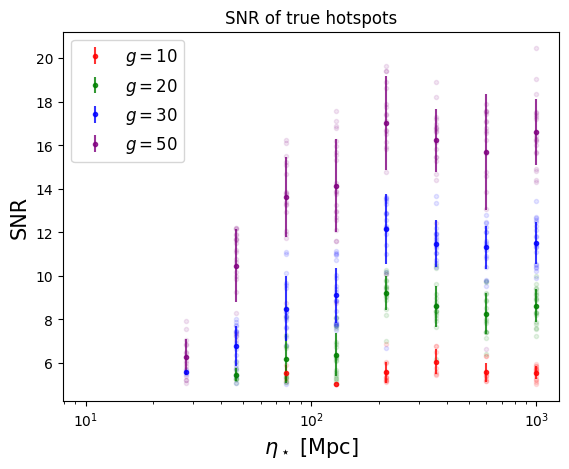

In [191]:
cs = ['','r','g','b','purple','orange','teal']
for gi,g in enumerate(gs):
    if g==0: continue
    
    means = []
    errs = []
    for eta_star in all_eta_star:
        f = np.where(true_cat['eta_stars']==eta_star)[0]
        all_stars = g_matchs[gi][0][f][:,2]
        means.append(all_stars[np.isfinite(all_stars)].mean())
        errs.append(all_stars[np.isfinite(all_stars)].std())
    plt.errorbar(all_eta_star,means,yerr=errs,ls='',marker='.',alpha=0.8,label=r'$g=%d$'%g,c=cs[gi])
   
plt.title("SNR of true hotspots")
for gi,g in enumerate(gs):
    if g==0: continue
    plt.scatter(true_cat['eta_stars'],g_matchs[gi][0][:,2],marker='.',alpha=0.1,c=cs[gi])
plt.xlabel(r'$\eta_\star$ [$\mathrm{Mpc}$]',fontsize=15);
plt.ylabel(r'SNR',fontsize=15);
plt.xscale('log');
plt.legend(fontsize=12);

**Do we recover the $\eta_\star$ correctly?**

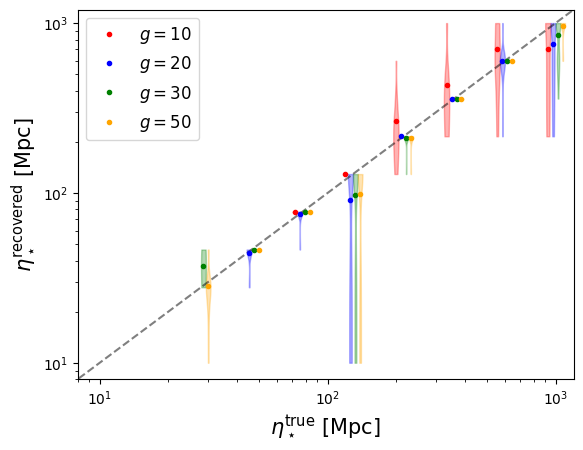

In [192]:
cs = ['k','r','b','g','orange']
#plt.title("Sizes of true hotspots")
for gi,g in enumerate(gs):
    if g==0: continue
    if g<5: continue
    dat = []
    tes = []
    for eta_star in all_eta_star:
        f = np.where(true_cat['eta_stars']==eta_star)[0]
        all_stars = g_matchs[gi][0][f][:,3]
        if np.sum(np.isfinite(all_stars))>0:
            dat.append(all_stars[np.isfinite(all_stars)])
            tes.append(eta_star)
    vp = plt.violinplot(dat, np.asarray(tes)*(1+(gi-2.5)/20.), widths=0.05*np.asarray(tes),showmeans=False,showextrema=False)
    plt.errorbar(np.asarray(tes)*(1+(gi-2.5)/20.), [np.mean(d) for d in dat], ls='',c=cs[gi],marker='.',label=r'$g=%d$'%g)#yerr=[np.std(d) for d in dat],l
    for pc in vp['bodies']:
        pc.set_color(cs[gi])
        pc.set_edgecolor(cs[gi])
        pc.set_alpha(0.3)
    
plt.xlabel(r'$\eta_\star^{\rm true}$ [$\mathrm{Mpc}$]',fontsize=15);
plt.ylabel(r'$\eta_\star^{\rm recovered}$ [$\mathrm{Mpc}$]',fontsize=15);
plt.xscale('log');
plt.xlim(8,1200);
plt.ylim(8,1200);
plt.legend(fontsize=12);
plt.yscale('log')
plt.plot(np.arange(1,10000),np.arange(1,10000),ls='--',alpha=0.5,c='k')
#plt.savefig('pub_plots/eta_test1.pdf',bbox_inches='tight')

**Do we recover $g$ correctly?**

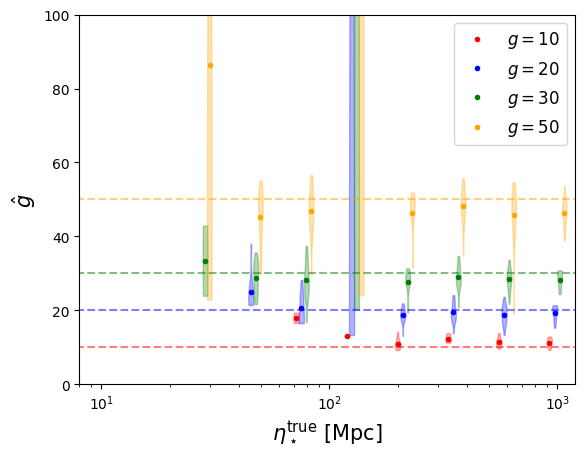

In [193]:
cs = ['k','r','b','g','orange']
for gi,g in enumerate(gs):
    if g==0: continue
    if g<5: continue
    dat = []
    tes = []
    for eta_star in all_eta_star:
        f = np.where(true_cat['eta_stars']==eta_star)[0]
        all_g = g_matchs[gi][0][f][:,5]
        if np.sum(np.isfinite(all_g))>0:
            dat.append(all_g[np.isfinite(all_g)])
            tes.append(eta_star)
    vp = plt.violinplot(dat, np.asarray(tes)*(1+(gi-2.5)/20.), widths=0.05*np.asarray(tes),showmeans=False,showextrema=False)
    plt.errorbar(np.asarray(tes)*(1+(gi-2.5)/20.), [np.mean(d) for d in dat], ls='',c=cs[gi],marker='.',label=r'$g=%d$'%g)
    for pc in vp['bodies']:
        pc.set_color(cs[gi])
        pc.set_edgecolor(cs[gi])
        pc.set_alpha(0.3)
    plt.hlines(g,0,1200,color=cs[gi],linestyles='--',alpha=0.5)
plt.xlabel(r'$\eta_\star^{\rm true}$ [$\mathrm{Mpc}$]',fontsize=15);
plt.ylabel(r'$\hat{g}$',fontsize=15);
plt.xscale('log');
plt.xlim(8,1200);
plt.ylim(0,100);
#plt.ylim(20,1200);
plt.legend(fontsize=12);
#plt.savefig('pub_plots/g_test1.pdf',bbox_inches='tight')

**What fraction of the input hotspots do we detect?**

(This won't asymptote to 1 due to the mask)

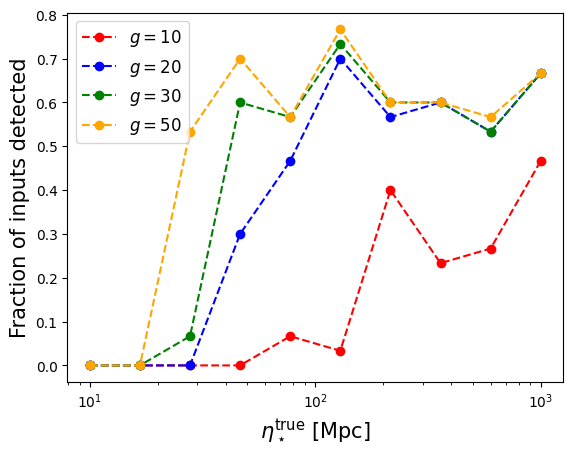

In [194]:
completeness = []
for gi,g in enumerate(gs):
    comp = []
    if g!=0:
        for eta_star in all_eta_star:
            f = np.where(true_cat['eta_stars']==eta_star)[0]
            comp.append(np.isfinite(g_matchs[gi][0][f,0]).sum()/len(f))            
    completeness.append(comp)

for gi, g in enumerate(gs):
    
    if g==0: continue
    
    plt.plot(all_eta_star,completeness[gi],marker='o',ls='--',c=cs[gi],alpha=1.,label=r'$g=%d$'%g)
    
plt.xlabel(r'$\eta_\star^{\rm true}$ [Mpc]',fontsize=15);
plt.ylabel(r'Fraction of inputs detected',fontsize=15);
plt.legend(fontsize=12);
plt.xscale('log');
#plt.savefig('pub_plots/comp_test1.pdf',bbox_inches='tight')

**What are the distributions of $g$ for true and fake sources?**

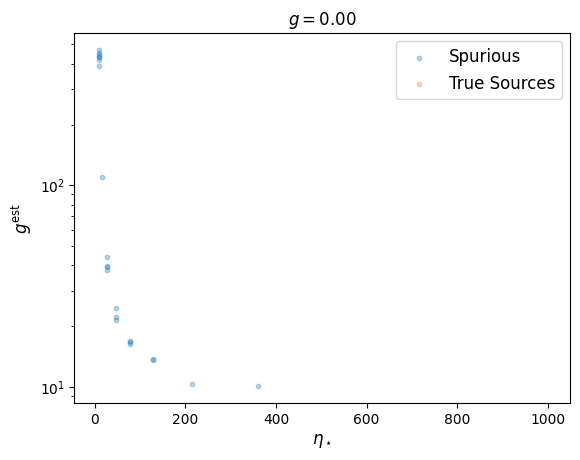

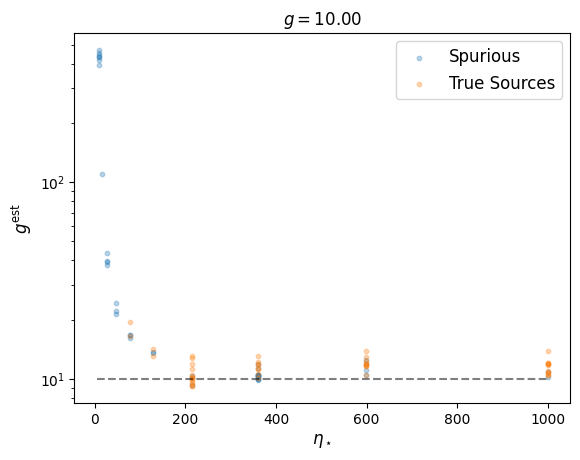

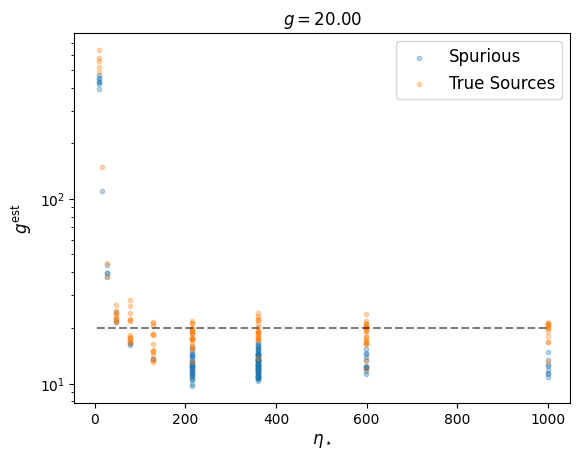

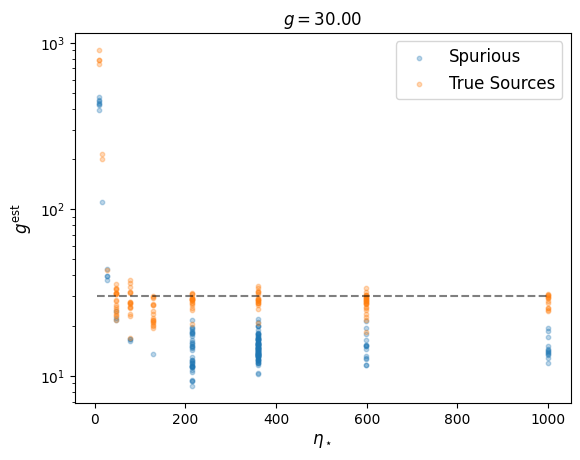

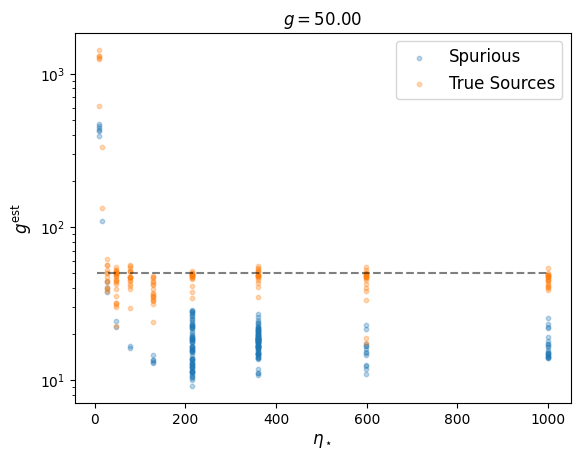

In [195]:
for gi,g in enumerate(gs):
    in_catalog = np.asarray([i in g_matchs[gi][1] for i in range(len(png_g_procs[gi].catalogue['y0']))])

    plt.figure()
    plt.title(r'$g=%.2f$'%g,fontsize=12);
    plt.scatter(png_g_procs[gi].catalogue['eta_star'][~in_catalog],png_g_procs[gi].catalogue['y0'][~in_catalog],alpha=0.3,s=10,label='Spurious')
    plt.scatter(png_g_procs[gi].catalogue['eta_star'][in_catalog],png_g_procs[gi].catalogue['y0'][in_catalog],alpha=0.3,s=10,label='True Sources')
    plt.hlines(g,5,1000,linestyles='--',color='k',alpha=0.5)
    plt.yscale('log');
    plt.legend(fontsize=12);
    plt.xlabel(r'$\eta_\star$',fontsize=12);
    plt.ylabel(r'$g^{\rm est}$',fontsize=12);

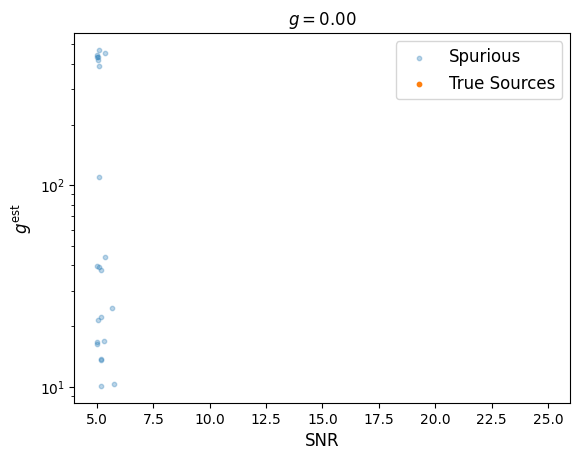

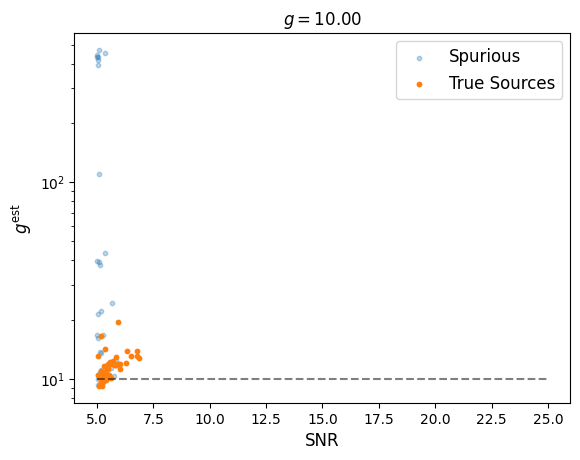

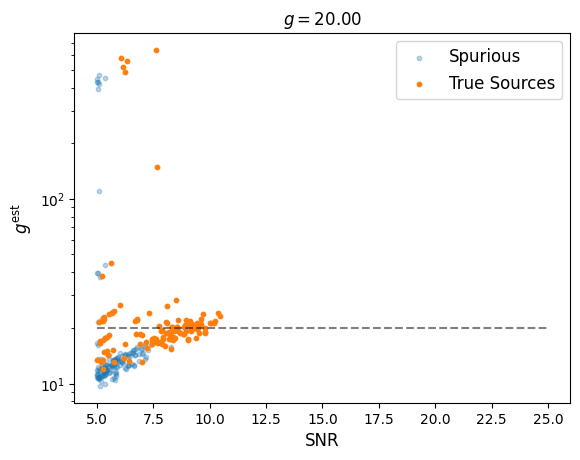

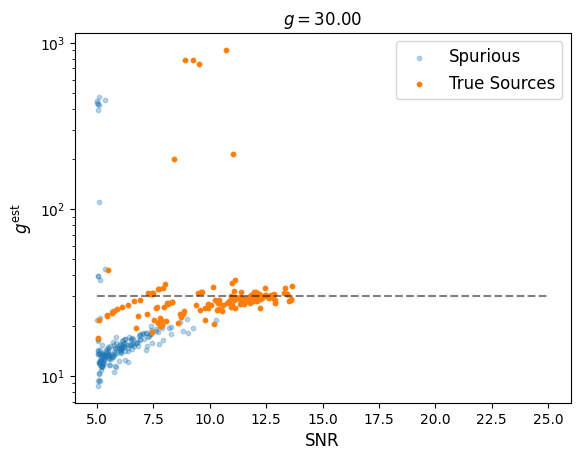

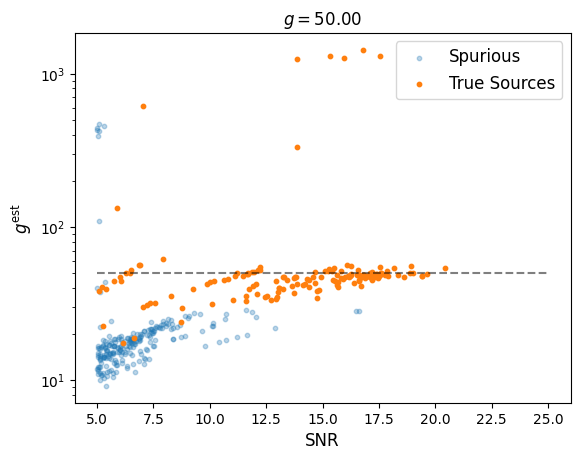

In [196]:
for gi,g in enumerate(gs):
    in_catalog = np.asarray([i in g_matchs[gi][1] for i in range(len(png_g_procs[gi].catalogue['y0']))])

    plt.figure()
    plt.title(r'$g=%.2f$'%g,fontsize=12);
    plt.scatter(png_g_procs[gi].catalogue['q_opt'][~in_catalog],png_g_procs[gi].catalogue['y0'][~in_catalog],alpha=0.3,s=10,label='Spurious')
    plt.scatter(png_g_procs[gi].catalogue['q_opt'][in_catalog],png_g_procs[gi].catalogue['y0'][in_catalog],alpha=1.0,s=10,label='True Sources')
    plt.hlines(g,5,25,linestyles='--',color='k',alpha=0.5)
    plt.yscale('log');
    plt.legend(fontsize=12);
    plt.xlabel(r'SNR',fontsize=12);
    plt.ylabel(r'$g^{\rm est}$',fontsize=12);

**What are the distribution of errors on $g$?** 
This encodes the sensititivity.

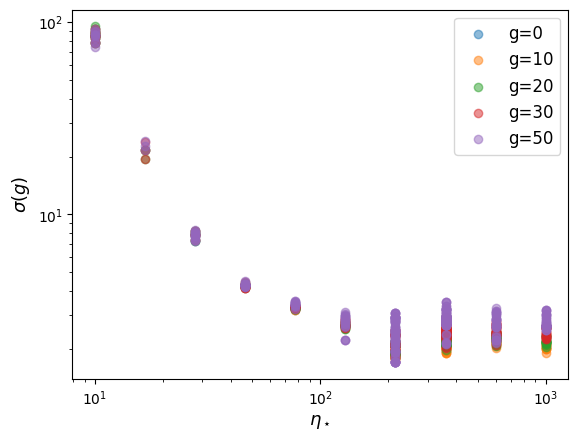

In [197]:
for gi,g in enumerate(gs):
    plt.scatter(png_g_procs[gi].catalogue['eta_star'],png_g_procs[gi].catalogue['y0']/png_g_procs[gi].catalogue['q_opt'],alpha=0.5,label=r'g=%d'%g)
plt.xlabel(r'$\eta_\star$',fontsize=13);
plt.ylabel(r'$\sigma(g)$',fontsize=13);
plt.legend(fontsize=12);
plt.yscale('log')
plt.xscale('log')

### Sensitivity Plot

Found 1861 PNG hotspots (SNR>4) from 78 catalogues


(8.0, 1200.0)

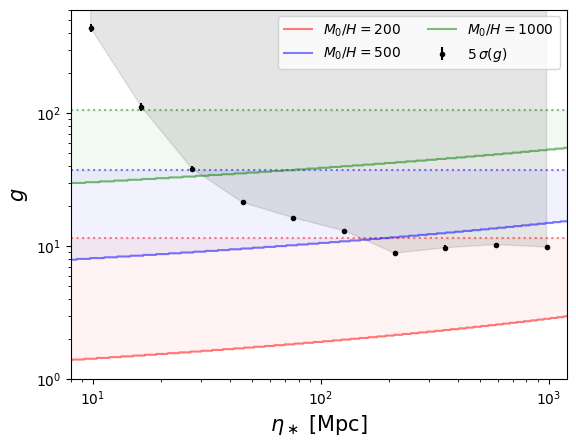

In [207]:
Delta_eta_s = 19
N_spots = lambda g, eta_star, M0_by_H: 4e8*g**(3./2.)*(Delta_eta_s/100.)*(100./eta_star)**3*np.exp(-np.pi*(M0_by_H**2-2.)/58.9**2/g)
backreaction = lambda g, M0_by_H: g/(8.*np.pi**3.)*(g*58.9)**(3./2.)*np.exp(-np.pi*(M0_by_H**2-2)/58.9**2/g)/(58.9**2)

# Load unprocessed source catalog
png_prep = cut_on_map(load_png_catalog(0), sz_mask)
peta_star = png_prep.catalogue['eta_star']
psig_g = png_prep.catalogue['y0']/png_prep.catalogue['q_opt']
sigs = []
errs = []
for eta_star in all_eta_star:
    f = np.where(peta_star==eta_star)[0]
    sigs.append(psig_g[f].mean())
    errs.append(psig_g[f].std())
plt.errorbar(all_eta_star*0.98, 5*np.asarray(sigs), yerr=5.*np.asarray(errs), alpha=1, label=r'$5\,\sigma(g)$', ls='',marker='.', c='k')
plt.fill_between(all_eta_star*0.98,5*np.asarray(sigs),1000.*np.asarray(sigs),alpha=0.1,color='k')

g_needed = []
M0s = [200,500,1000]
eta_star_all = np.geomspace(min(peta_star)*0.8,max(peta_star)*1.2,1000)
for i in range(len(eta_star_all)):
    g_all = np.geomspace(1e-3,1000,1000)
    g_needed.append([g_all[np.where(N_spots(g_all, eta_star_all[i], M0)>1)[0][0]] for M0 in M0s])

g_back = []
for i in range(len(eta_star_all)):
    g_all = np.geomspace(1e-3,1000,1000)
    g_back.append([g_all[np.where(backreaction(g_all, M0)>0.01)[0][0]] for M0 in M0s])

cs = ['r','b','g','purple']
for i in range(len(M0s)):
    plt.fill_between(eta_star_all,np.asarray(g_needed)[:,i],np.asarray(g_back)[:,i],alpha=0.05,color=cs[i])
    plt.plot(eta_star_all,np.asarray(g_needed)[:,i],label=r'$M_0/H=%d$'%(M0s[i]),alpha=0.5,c=cs[i])
    plt.plot(eta_star_all,np.asarray(g_back)[:,i],alpha=0.5,c=cs[i],ls=':')
plt.ylim(1,600);
plt.yscale('log')
plt.xscale('log')
plt.legend(ncol=2);
plt.xlabel(r'$\eta_\ast$ [Mpc]',fontsize=15);
plt.ylabel(r'$g$',fontsize=15);
plt.xlim(min(eta_star_all),max(eta_star_all))
#plt.savefig('pub_plots/exclusion_plot.pdf',bbox_inches='tight')